Notebook vorarbeit für die einzelnen py-sricpts

In [100]:
#

# txtreader

In [101]:
import os
import pandas as pd

type_dict = {"etf-complete": "ETF", "us3000": "stock", "usindex": "index"}


class DataReader():
    """
    The class is used to read the data from the files.
    """

    def __init__(self, config: dict, data_dir_name: str = "data"):
        """
        Initializes a data reader.

        Args:
            config (dict): Dictionary for the configuration of data preprocessing.
            data_dir_name (str, optional): Directory in which the data is located. Defaults to "data".

        It is expected that the files containing the data are located in subdirectories. \n
        C:. \n
        ├───data \n
        │   ├───etf-complete_tickers_A-C_1min_w1q7w \n
        │   ├───... \n
        │   ├───us3000_tickers_Y-Z_1min_v264r \n      
        │   └───usindex_1min_u8d0l \n
        """

        # Dictionary for the configuration of data preprocessing is saved.
        self.config = config

        self.root_folder = data_dir_name
        # A list containing all file names and a list containing all symbols are created.
        self.txt_files, self.symbols = self.get_txt_files()
        # Counter, so that one file after the other can be read from the list of file names.
        self.current_file_idx = 0

    def get_txt_files(self) -> tuple[list, list]:
        """
        Returns a list with the paths of all read txt files and a list with all symbols.

        Returns:
            tuple[list, list]: List with paths of all read txt files and list with all symbols
        """
        txt_files, symbols = [], []
        # Traverse subdirectories.
        for root, dirs, files in os.walk(self.root_folder):
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                # In the subdirectory all files are traversed.
                for inner_root, inner_dirs, inner_files in os.walk(dir_path):
                    for file in inner_files:
                        symbol = file.split("_")[0]
                        if self.config["READ_ALL_FILES"] or self.root_folder.endswith("test"):
                            # The paths of all text files are stored in a list.
                            if file.endswith(".txt"):
                                txt_files.append(os.path.join(dir_path, file))
                                symbols.append(symbol)
                        else:
                            # The paths of all text files selected via the symbols
                            # in the configuration file are saved in a list.
                            if file.endswith(".txt") and symbol in self.config["SYMBOLS_TO_READ"]:
                                txt_files.append(os.path.join(dir_path, file))
                                symbols.append(symbol)
        return txt_files, symbols

    def _get_type(self, file_path: str) -> str:
        """
        Returns the type of the data based on the path of the file.

        Args:
            file_path (str): path of the file

        Returns:
            str: type of data (EFT, stock, index)
        """
        directory = os.path.dirname(file_path)
        folder_name = os.path.basename(directory)
        for key in type_dict:
            if key in folder_name:
                return type_dict.get(key)
        return None

    def read_next_txt(self) -> pd.DataFrame:
        """
        Reads in the next file if there are files that have not yet been read in.

        Returns:
            pd.DataFrame: Read in file.
        """
        # Check if there are files that have not been read in yet.
        if self.current_file_idx < len(self.txt_files):
            file_to_read = self.txt_files[self.current_file_idx]

            # Read in file.
            data = pd.read_csv(file_to_read, names=[
                               "timestamp", "open", "high", "low", "close", "volume"])

            # Replace Nan vaules in voulme column with 0. Indices do not have a volume.
            data["volume"] = data["volume"].fillna(0)

            # The ticker symbol to which the data belongs is included in the file name.
            filename = os.path.basename(file_to_read)
            data["symbol"] = filename.split("_")[0]

            # The type of the data is determined based on the path of the file.
            data["type"] = self._get_type(file_to_read)

            # Convert timestamp to python timestamp.
            data["timestamp"] = pd.to_datetime(
                data["timestamp"], format="%Y-%m-%d %H:%M:%S")

            self.current_file_idx += 1
            return data
        else:
            # No more files to read
            return None

# data cleaning

In [102]:
import pandas as pd
import numpy as np

class DataCleaner:
    def __init__(self, raw_data: pd.DataFrame):
        self.raw_data = raw_data.set_index("timestamp")
        self.raw_data = self.raw_data.drop(["type"], axis=1)
        self.raw_data = self.raw_data.drop(["symbol"], axis=1)
        self.difference = []

        # Die Daten auf offizielle Handelszeiten setzen
        self.raw_data = self.raw_data.between_time('09:30', '16:00')

        # Erstellen verschiedener Zeitintervall-DataFrames
        self.df_normal = self.normal()  
        self.df_hourly = self.hourly()
        self.df_minute = self.minute()
        self.df_daily = self.daily()
        self.df_busi = self.busi()
    
    def normal(self):
        return self.raw_data
    
    def hourly(self):
        hourly = self.raw_data.resample('H').mean()
        return hourly.ffill()
    
    def minute(self):
        minute = self.raw_data.resample('min').mean()
        minute = minute.between_time('09:30', '16:00')
        return minute.ffill()
    
    def daily(self):
        daily = self.raw_data.between_time('16:00:00', '16:00:00')
        daily = daily.resample('D').mean()
        return daily.ffill()
    
    def busi(self):
        busi = self.raw_data.between_time('16:00:00', '16:00:00')
        busi = busi.resample('B').mean()
        return busi.ffill()

# feature

In [103]:
### Features erstellen

import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import (LagFeatures, WindowFeatures,)
from feature_engine.creation import CyclicalFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures

data_columns = ['open', 'high', 'low', 'close', 'volume']

####################################################################
######################### Feature Pipeline #########################

####################################################################
### jeden df
def add_day_name():
    def transform(data):
        df = data.copy()
        df["day_name"] = df.index.day_name()
        return df
    return transform
day_name_transformer = FunctionTransformer(add_day_name())  # anpassen, sodass Funktion in eine Pipeline integriert werden kann
    
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    # the features we want to create
    features_to_extract=[
        "week",
        "month",
        "day_of_week",  #0=monday, ... 6=sunday
        "day_of_month",
        "hour",
        "weekend",
       ],
)

#create differenz + pct_change
def create_differenz_value(df):
    for col in data_columns:
        df[col + '_Differenz'] = df[col].diff()
    return df
differenz_value = FunctionTransformer(create_differenz_value)

def create_differenz_and_pct_change(data):
    df = data.copy()
    for col in data_columns:
        if col in data_columns:
            df.loc[:, col + '_Differenz'] = df[col].diff() # Berechnung der Differenz
            df.loc[:, col + '_PctChange'] = df[col].pct_change() * 100 # Berechnung der prozentualen Änderung # Multipliziert mit 100, um es in Prozent auszudrücken
    return df
differenz_pct_change_transformer = FunctionTransformer(create_differenz_and_pct_change)

###### 
# Drop missing data
imputer = DropMissingData()

#drop infinitiv valuess
def remove_infinite_values(df):
    # Ersetzt sowohl positive als auch negative unendliche Werte durch NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True) # Entfernt alle Zeilen mit NaN-Werten
    return df
remove_infinite = FunctionTransformer(remove_infinite_values)

# Drop original time series
drop_ts = DropFeatures(features_to_drop=['open', 'high', 'low', 'close', 'volume'])


####################################################################
### df normal / minütlich && if dtf is made
def create_window_feature(data):
    df = data.copy()
    for col in data_columns:
        if col in data_columns:
            # Berechnen des durchschnittlichen Wertes der Spalte pro Stunde
            average_value_per_hour = df.groupby('hour')[col].transform('mean')
            df[col + '_average_per_hour'] = average_value_per_hour

    return df
window_feature_transformer = FunctionTransformer(create_window_feature) #kw_args={'data_columns': data_columns}

####################################################################
### df hourly 

#lag feature backward mit 1h - 7h 
def create_lag_features_backward(data, max_lag_hours=7):
    df = data.copy()
    for col in data_columns:
        for lag_hour in range(1, max_lag_hours + 1):
            df[f'{col}_lag_{lag_hour}H_back'] = data[col].shift(lag_hour)
    return df
lag_backward_features= FunctionTransformer(create_lag_features_backward) # Erstellen einer  FunctionTransformer-Instanz um es in die Pipeline aufnehmen zu können

#lag feature foreward mit 1h - 7h 
def create_lag_features_forward(data, max_lag_hours=7):
    df = data.copy()
    for col in data_columns:
        for lag_hour in range(1, max_lag_hours + 1):
            df[f'{col}_lag_{lag_hour}H_forward'] = data[col].shift(-lag_hour)
    return df
lag_forward_features= FunctionTransformer(create_lag_features_forward)

def replace_weekend_volume_with_zero(data):
    # Kopie des DataFrame erstellen, um das Original nicht zu ändern
    df = data.copy()
    # Ersetze das 'Volume'-Attribut auf 0 für Wochenenden (wenn 'weekend' gleich 1 ist)
    df.loc[df['weekend'] == 1, 'volume'] = 0
    return df
replace_weekend_volume = FunctionTransformer(replace_weekend_volume_with_zero)




####################################################################
# Class FeatureEngineering
class FeatureEngineering:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.data_columns = ['open', 'high', 'low', 'close', 'volume']
    



####################################################################
######################### andere Features #########################
##################################################-> nicht pipeline
#return pct change
def revert_pct_change(initial_value, pct_changes):
    """
    Rekonstruiert die ursprünglichen Werte aus der prozentualen Änderung.

    :param initial_value: Der erste Wert der ursprünglichen Zeitreihe.
    :param pct_changes: Eine Serie oder Liste von prozentualen Änderungen.
    :return: Eine Liste der rekonstruierten Werte.
    """
    current_value = initial_value
    original_values = [current_value]

    for change in pct_changes[1:]:  # Erster Wert bereits bekannt
        # Berechnung des nächsten Wertes
        next_value = current_value * (1 + change / 100)
        original_values.append(next_value)
        current_value = next_value

    return original_values


# pipeline

In [104]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from feature_ts import FeatureEngineering

from feature_ts import day_name_transformer, dtf, replace_weekend_volume, imputer, drop_ts, remove_infinite
from feature_ts import differenz_value, differenz_pct_change_transformer
from feature_ts import lag_backward_features, lag_forward_features
from feature_ts import window_feature_transformer


class ClassPipeline:
    def __init__(self, data):

        self.data = data
        # Initialisierung der FeatureEngineering-Klasse mit den Daten
        feature_engineering = FeatureEngineering(self.data)

        self.pipe_all = Pipeline( ##alle Features die es aktuell gibt
            [
                # for all
                ("day_name", day_name_transformer),
                ("datetime_features", dtf),
                ("replace_weekend_volume", replace_weekend_volume),
                ("value_differenz", differenz_value),
                ("pct_dif", differenz_pct_change_transformer),

                #for normal / minütlich, only with dtf
                ("window_feature_transformer", window_feature_transformer), #mit dtf ! -> ("datetime_features", dtf),

                # for hourly
                ("lag_features_back", lag_backward_features),
                ("lag_features_for", lag_forward_features),

                # last ones
                ("dropna", imputer),
                ("remove_infinite", remove_infinite),
                ("drop_ts", drop_ts),
            ]
        )

        self.pipe_h = Pipeline( #hourly df
            [
                ("create_differenz", differenz_value),
                ("datetime_features", dtf),
                ("lag_features_back", lag_backward_features),
                ("replace_weekend_volume", replace_weekend_volume),
                ("dropna", imputer),
            ]
        )

        self.pipe_test = Pipeline(
            [
                ("datetime_features", dtf),
                ("replace_weekend_volume", replace_weekend_volume),
                ("window_feature_transformer", window_feature_transformer),
                ("pct_dif", differenz_pct_change_transformer),
                ("remove_infinite", remove_infinite),
                ("dropna", imputer),
            ]
        )

    def fit_transform(self, data, pipeline_name):
        if pipeline_name == 'all':
            return self.pipe_all.fit_transform(data)
        elif pipeline_name == 'h':
            return self.pipe_h.fit_transform(data)
        elif pipeline_name == 'test':
            return self.pipe_test.fit_transform(data)
        else:
            raise ValueError("Unbekannter Pipeline-Name")




# split

In [105]:
class DataSplitter:
    def __init__(self, data, split_ratio=0.8):
    
        self.data = data
        self.split_ratio = split_ratio
        self.train_data = None
        self.test_data = None

    def split(self): #Split der Daten in Train und Test
        split_index = int(len(self.data) * self.split_ratio)
        self.train_data = self.data.iloc[:split_index]
        self.test_data = self.data.iloc[split_index:]

    def get_train_data(self):
        return self.train_data

    def get_test_data(self):
        return self.test_data



# ml model

In [106]:
#modelle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# evaluation metric 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

############### LR ##################### 
class LinearRegressionModel:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, predictions, y_test):
        evaluation_results = {
            "MAE": mean_absolute_error(y_test, predictions),
            "RMSE": mean_squared_error(y_test, predictions, squared=False),
            #"MSLE": mean_squared_log_error(y_test, predictions),
            #"Median AE": median_absolute_error(y_test, predictions),
        }
        return evaluation_results

    def vs (self, X_test, y_test):
        variance_score = {
            "Variance Score": self.model.score(X_test, y_test),
        }
        return variance_score
    
    def coef(self):
        coef_results = {
            "Coefficients": self.model.coef_,
        }
        return coef_results

############### RF ##################### 
class RandomForestModel:
    def __init__(self, n_estimators=10, max_depth=10, min_samples_split=2, min_samples_leaf=1):
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf
        )

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, predictions, y_test):
        evaluation_results = {
            "MAE": mean_absolute_error(y_test, predictions),
            "RMSE": mean_squared_error(y_test, predictions, squared=False),
            #"MSLE": mean_squared_log_error(y_test, predictions),
            #"Median AE": median_absolute_error(y_test, predictions),
        }
        return evaluation_results
    
    def fi(self):
        rf_feature_importances = {
            "Feature Importances": self.model.feature_importances_
        }
        return rf_feature_importances


############### GBM ##################### 
class GradientBoostingModel:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth
        )

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, predictions, y_test):
        evaluation_results = {
            "MAE": mean_absolute_error(y_test, predictions),
            "RMSE": mean_squared_error(y_test, predictions, squared=False),
            #"MSLE": mean_squared_log_error(y_test, predictions),
            #"Median AE": median_absolute_error(y_test, predictions),
        }
        return evaluation_results
    
    def fi(self):
        gbm_feature_importances = {
            "Feature Importances": self.model.feature_importances_
        }
        return gbm_feature_importances



############### SVM ##################### 
class SVMModel:
    def __init__(self, kernel='rbf', C=1.0, epsilon=0.1):
        self.model = SVR(kernel=kernel, C=C, epsilon=epsilon)

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, predictions, y_test):
        evaluation_results = {
            "MAE": mean_absolute_error(y_test, predictions),
            "RMSE": mean_squared_error(y_test, predictions, squared=False),
            #"MSLE": mean_squared_log_error(y_test, predictions),
            #"Median AE": median_absolute_error(y_test, predictions),
        }
        return evaluation_results


# script

In [107]:
#Package einlesen
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#classe / other scripts
from txtReader import DataReader
from data_cleaning import DataCleaner
from feature_ts import FeatureEngineering, revert_pct_change
from pipeline import ClassPipeline
from split import DataSplitter
from ml_model import LinearRegressionModel, RandomForestModel, GradientBoostingModel, SVMModel



## teil vor splitt & ml modelle

In [108]:
### main

data = DataReader({"READ_ALL_FILES": "READ_ALL_FILES"})
txt_files, symbols = data.get_txt_files()
 
# Test for-Schleife später löschen
for i in symbols:
    print(i)

# 0 = AAL, 1 = AAPL, ...   #von den 10 datas
data.current_file_idx = 1
df = data.read_next_txt()
print("\nData:", df.symbol[0], "\n")

data_columns = df.columns
print(data_columns) #nur zum testen

#Data clean
cleaner = DataCleaner(df)

df_normal = cleaner.normal()
df_hourly = cleaner.hourly()
df_minute = cleaner.minute()
df_daily = cleaner.daily()

df_normal

data_columns = df_normal.columns
print(data_columns, "\n")


#features + pipeline
data = df_normal

# Anwendung der Pipeline
pipeline = ClassPipeline(data)

data_pip = pipeline.fit_transform(data, 'test')
print(data_pip.columns)
print(data_pip)
print("pip läuft \n")


AAL
AAPL
AMD
C
MRNA
NIO
NVDA
SNAP
SQ
TSLA

Data: AAPL 

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'symbol',
       'type'],
      dtype='object')
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object') 

Index(['open', 'high', 'low', 'close', 'volume', 'week', 'month',
       'day_of_week', 'day_of_month', 'hour', 'weekend',
       'open_average_per_hour', 'high_average_per_hour',
       'low_average_per_hour', 'close_average_per_hour',
       'volume_average_per_hour', 'open_Differenz', 'open_PctChange',
       'high_Differenz', 'high_PctChange', 'low_Differenz', 'low_PctChange',
       'close_Differenz', 'close_PctChange', 'volume_Differenz',
       'volume_PctChange'],
      dtype='object')
                         open      high       low     close    volume  week  \
timestamp                                                                     
2004-01-02 09:31:00    0.3315    0.3336    0.3313    0.3332    964936     1   
2004-01-02 09:32:00    0.3332 

## teil: splitt & ml modelle

Trainingsdaten:
                         open     high      low    close   volume
timestamp                                                       
2004-01-02 09:30:00   0.3315   0.3330   0.3313   0.3327  2113944
2004-01-02 09:31:00   0.3315   0.3336   0.3313   0.3332   964936
2004-01-02 09:32:00   0.3332   0.3346   0.3327   0.3346  1960952
2004-01-02 09:33:00   0.3344   0.3346   0.3338   0.3344   459200
2004-01-02 09:34:00   0.3344   0.3346   0.3338   0.3338   584416
...                      ...      ...      ...      ...      ...
2017-10-09 16:00:00  37.3011  37.3155  37.3011  37.3035  6034344
2017-10-10 09:30:00  37.3394  37.3801  37.3179  37.3592  1613504
2017-10-10 09:31:00  37.3586  37.4256  37.3562  37.3885   730764
2017-10-10 09:32:00  37.3897  37.4184  37.3681  37.3873   347332
2017-10-10 09:33:00  37.3849  37.4040  37.3418  37.4005   337204

[1351445 rows x 5 columns]
Testdaten:
                         open     high      low    close    volume
timestamp                       

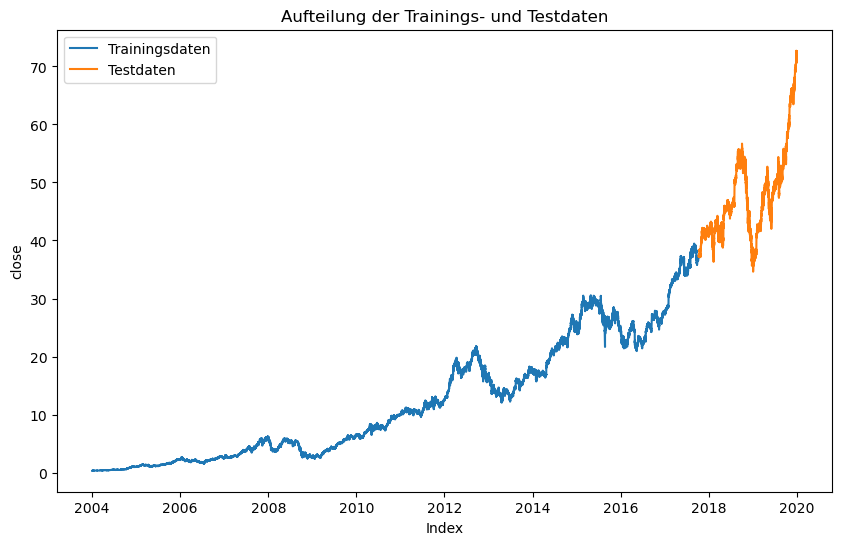

In [109]:
# Verwendung der Klasse zum splitten der Daten aktuell erstmal train test 80-20
splitter = DataSplitter(data)

splitter.split()
train_data = splitter.get_train_data()
test_data = splitter.get_test_data()

#kürzen
test_data = test_data[test_data.index <= pd.Timestamp('2019-12-31 16:00:00')]
test_data

print("Trainingsdaten:\n", train_data)
print("Testdaten:\n", test_data)

# Plot um die aufteilung anzusehen
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['close'], label='Trainingsdaten')
plt.plot(test_data.index, test_data['close'], label='Testdaten')
plt.title('Aufteilung der Trainings- und Testdaten')
plt.xlabel('Index')
plt.ylabel('close')
plt.legend()
#plt.show()
print("plot done \n") #nur zum testen

####
#spltt data durch pipeline
train_data = pipeline.fit_transform(train_data, 'test')
test_data = pipeline.fit_transform(test_data, 'test')

print(train_data)
print(train_data.columns)
print("split pip done \n") #nur zum testen

######## Prüfen von NaN / zu große Werte / oder infintiv value ################
# Überprüfen auf extrem große Werte
max_float64 = np.finfo(np.float64).max
min_float64 = np.finfo(np.float64).min
print('Maximaler Wert in train_data:', train_data.max().max())
print('Maximaler Wert in test_data:', test_data.max().max())
print('Werte in train_data außerhalb des float64 Bereichs:', ((train_data > max_float64) | (train_data < min_float64)).sum().sum())
print('Werte in test_data außerhalb des float64 Bereichs:', ((test_data > max_float64) | (test_data < min_float64)).sum())

print('Anzahl der NaN-Werte in train_data:', train_data.isna().sum().sum()) # Überprüfung auf NaN Werte
print('Anzahl der unendlichen Werte in train_data:', np.isinf(train_data).sum().sum()) # Überprüfung auf unendliche Werte
print('Anzahl der NaN-Werte in test_data:', test_data.isna().sum().sum()) # Überprüfung auf NaN Werte
print('Anzahl der unendlichen Werte in test_data:', np.isinf(test_data).sum().sum()) # Überprüfung auf unendliche Werte
print("\prüfung done \n")
#########################

# Feature (X = unabhängige Variable) und Ziel (y = abhängige Variable) 
# Zielvariable 'Close'
X_train = train_data[train_data.index < test_data.index.min()]
X_test = test_data[test_data.index >= test_data.index.min()]

#X_train.drop(["close"], axis=1, inplace=True)
#X_test.drop(["close"], axis=1, inplace=True)

X_train.drop(["close_PctChange"], axis=1, inplace=True)
X_test.drop(["close_PctChange"], axis=1, inplace=True)
X_train.drop(["close_Differenz"], axis=1, inplace=True)
X_test.drop(["close_Differenz"], axis=1, inplace=True)

print(X_train.columns)

#y_train = train_data[train_data.index < test_data.index.min()]['close']
#y_test = test_data[test_data.index >= test_data.index.min()]['close']

y_train = train_data[train_data.index < test_data.index.min()]['close_PctChange']
y_test = test_data[test_data.index >= test_data.index.min()]['close_PctChange']

print(X_train)
print(y_train)

print("done, now ml-model \n") #nur zum testen

In [110]:

####### Verwendung der ML-Modelle #########
# Initialisierung und Training des linearen Regressionsmodells
lr_model = LinearRegressionModel()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_evaluation_results = lr_model.evaluate(lr_predictions, y_test)
lr_variance_score = lr_model.vs(X_test, y_test)
lr_coefficients = lr_model.coef()
print("lr done\n")

# Initialisierung und Training des Random Forest-Modells
rf_model = RandomForestModel( # Hyperparameter beim nächsten mal weiter anpassen
    n_estimators=10,      # Anpassen der Anzahl der Bäume im Wald
    max_depth=10,         # Anpassen der maximalen Tiefe der Bäume (None bedeutet keine Begrenzung)
    min_samples_split=2,  # Anpassen der Mindestanzahl von Beispielen, die für einen Split erforderlich sind
    min_samples_leaf=1    # Anpassen der Mindestanzahl von Beispielen in einem Blattknoten
)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_evaluation_results = rf_model.evaluate(rf_predictions, y_test)
rf_feature_importances = rf_model.fi()
print("rf done\n")

# Initialisierung und Training des Gradient Boosting-Modells
gbm_model = GradientBoostingModel( # Hyperparameter beim nächsten mal weiter anpassen
    n_estimators=10,    # Die Anzahl der Bäume im GBM-Ensemble
    learning_rate=0.1,  # Die Lernrate, die angibt, wie stark jeder Baum die Vorhersagen beeinflusst
    max_depth=3         # Die maximale Tiefe der Bäume im GBM
    )
gbm_model.fit(X_train, y_train)
gbm_predictions = gbm_model.predict(X_test)
gbm_evaluation_results = gbm_model.evaluate(gbm_predictions, y_test)
gbm_feature_importances = gbm_model.fi()
print("gbm done\n")

# Initialisierung und Training des SVM-Modells
#svm_model = SVMModel(kernel='rbf', C=1.0, epsilon=0.1)
#svm_model.fit(X_train, y_train)
#svm_predictions = svm_model.predict(X_test)
#svm_evaluation_results = svm_model.evaluate(svm_predictions, y_test)
#print("svm done\n")

print("modelle fertig trainiert\n") #nur zum testen


lr done

rf done

gbm done

modelle fertig trainiert



Ausgabe der Evaluierungsergebnisse 

Linear Regression Evaluation:
MAE: 0.17222332461903295
RMSE: 0.18653552264030795

Linear Regression Variance Score:
Variance Score: -4.009982055780821

Linear Regression Coefficients:
Coefficients: [ 6.86622554e-01 -3.76903379e+00 -3.58372431e+00  6.66619186e+00
  8.16242185e-10  3.25922673e-07  2.13031288e-05  1.98231848e-05
 -1.65221025e-06 -2.55475802e-04  3.61081165e-11  3.30296897e+01
 -3.87561359e+01 -3.73894482e+01  4.31208600e+01  1.77755533e-09
  5.66543290e-01 -4.13611363e-01  2.44545644e-01  4.82048878e-01
 -7.75087443e-01  6.63664861e-01  1.12998374e-09  5.51749371e-07]

Random Forest Evaluation:
MAE: 0.022306944101022
RMSE: 0.03874044522637024

Random Forest Feature Importances:
Feature Importances: [3.86220925e-04 3.94102061e-04 2.16518000e-04 4.86977018e-04
 3.85169655e-03 1.13781381e-03 2.64451345e-04 1.66979177e-04
 5.83802836e-04 7.90941824e-04 0.00000000e+00 1.42351557e-04
 1.77089754e-04 3.79814420e-04 1.19555578e-04 2.32843850e-

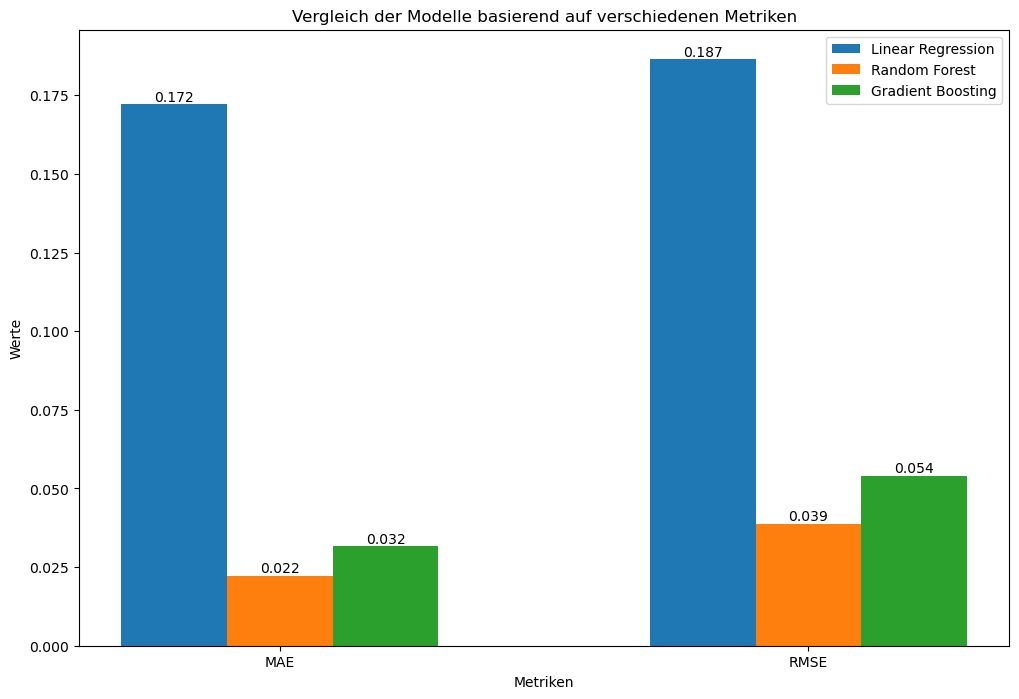

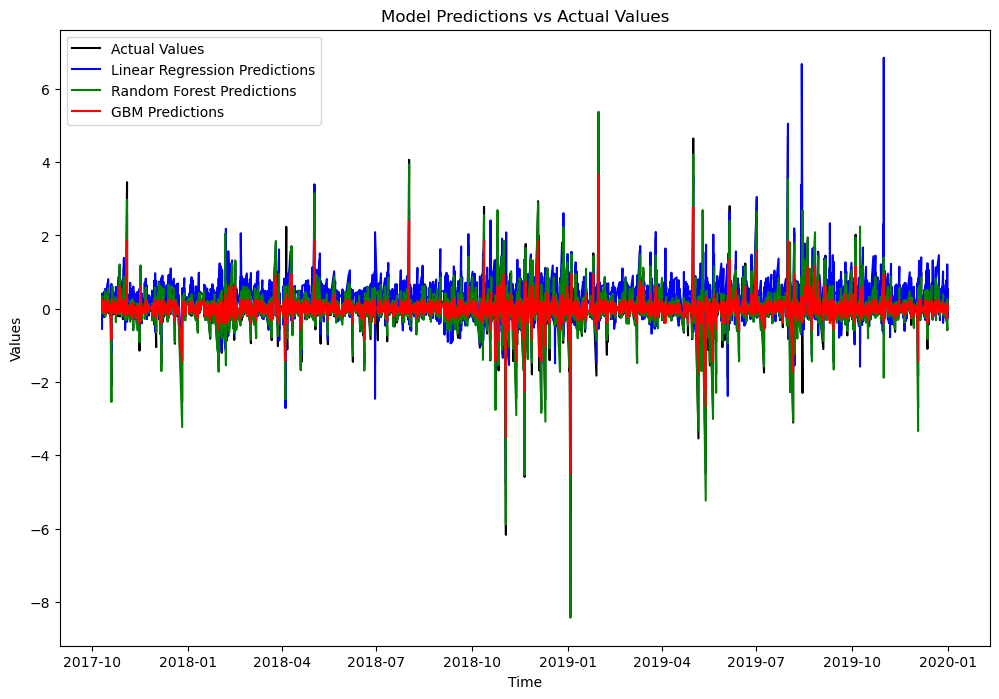

In [111]:
print("Ausgabe der Evaluierungsergebnisse \n") #nur zum testen

#### Ausgabe der Evaluierungsergebnisse
# LR
print("Linear Regression Evaluation:")
for key, value in lr_evaluation_results.items():
    print(f"{key}: {value}")

print("\nLinear Regression Variance Score:")
for key, value in lr_variance_score.items():
    print(f"{key}: {value}")

print("\nLinear Regression Coefficients:")
for key, value in lr_coefficients.items():
    print(f"{key}: {value}")

#####
# RF
print("\nRandom Forest Evaluation:")
for key, value in rf_evaluation_results.items():
    print(f"{key}: {value}")

print("\nRandom Forest Feature Importances:")
for key, value in rf_feature_importances.items():
    print(f"{key}: {value}")

# GBM
print("\nGradient Boosting Machine Evaluation:")
for key, value in gbm_evaluation_results.items():
    print(f"{key}: {value}")

print("\nGBM Feature Importances:")
for key, value in gbm_feature_importances.items():
    print(f"{key}: {value}")

# SVM
#print("\nSVM Evaluation:")
#for key, value in svm_evaluation_results.items():
 #   print(f"{key}: {value}")

print("\n")

###### plot der ergebnisse
evaluation_results = {
    'Linear Regression': lr_evaluation_results,
    'Random Forest': rf_evaluation_results,
    'Gradient Boosting': gbm_evaluation_results,
    #'SVM': svm_evaluation_results
}
# Metriken, die Sie vergleichen möchten
metrics = ['MAE', 'RMSE'] #, 'MSLE', 'Median AE']
n_models = len(evaluation_results)
n_metrics = len(metrics)

# Daten für das gruppierte Balkendiagramm vorbereiten
data = np.array([[evaluation_results[model][metric] for metric in metrics] for model in evaluation_results])

# X-Achsen-Positionen für jedes Modell
x = np.arange(n_metrics)
bar_width = 0.2  # Breite der Balken
plt.figure(figsize=(12, 8))
for i in range(n_models):
    bars = plt.bar(x + i * bar_width, data[i], width=bar_width, label=list(evaluation_results.keys())[i])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Metriken')
plt.ylabel('Werte')
plt.title('Vergleich der Modelle basierend auf verschiedenen Metriken')
plt.xticks(x + bar_width * (n_models - 1) / 2, metrics)
plt.legend()
#plt.show()

print("plot done\n")

#plot ml modelle
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, color='black', label='Actual Values') # Tatsächliche Werte
plt.plot(y_test.index, lr_predictions, color='blue', label='Linear Regression Predictions')# Vorhersagen der linearen Regression
plt.plot(y_test.index, rf_predictions, color='green', label='Random Forest Predictions')# Vorhersagen des Random Forest
plt.plot(y_test.index, gbm_predictions, color='red', label='GBM Predictions') # Vorhersagen der GBM
#plt.plot(y_test.index, svm_predictions, color='orange', label='SVM Predictions') # Vorhersagen der SVM
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# test

In [112]:
lr_predictions

array([-0.54843672, -0.25752567,  0.31009902, ...,  0.21154893,
       -0.03542059,  0.52683751])

In [113]:
### alle prediction der modelle in einen datensatz
def combine_predictions(predictions_data): #svm_predictions
    """
    Kombiniert Vorhersagen aus verschiedenen Modellen in einen DataFrame.

    :param lr_predictions: Vorhersagen aus dem Linear Regression Modell.
    :param rf_predictions: Vorhersagen aus dem Random Forest Modell.
    :param gbm_predictions: Vorhersagen aus dem Gradient Boosting Machine Modell.
    :param svm_predictions: Vorhersage aus dem SVM Modell.
    :return: Ein DataFrame mit allen kombinierten Vorhersagen.
    """

    # Überprüfen, ob alle Vorhersagen die gleiche Länge haben
    if not (len(lr_predictions) == len(rf_predictions) == len(gbm_predictions)):
        raise ValueError("Alle Vorhersagen müssen die gleiche Länge haben.")

    # Erstellen eines DataFrame
    predictions_data = pd.DataFrame({
        'lr_prediction': lr_predictions,
        'rf_prediction': rf_predictions,
        'gbm_prediction': gbm_predictions
    })

    return predictions_data

combine_predictions_transformer = FunctionTransformer(combine_predictions)

predictions_data = [lr_predictions, rf_predictions, gbm_predictions]

ml_prediction = combine_predictions_transformer.transform(predictions_data)

In [114]:
ml_prediction

,lr_prediction,rf_prediction,gbm_prediction
0,-0.548437,0.331210,0.233985
1,-0.257526,-0.009993,0.001186
2,0.310099,0.001910,0.005038
3,0.171219,0.038193,0.022248
4,0.173751,0.001237,0.001186
...,...,...,...
218311,0.061698,-0.033015,-0.001856
218312,0.081746,-0.017080,-0.010209
218313,0.211549,0.001237,0.001186
218314,-0.035421,-0.010224,0.009781


In [115]:
original_last_data = X_test["close"][0]  #ersten Werte aus X_test
predictions_pct_change = ml_prediction

print(original_last_data)
print(predictions_pct_change.columns)


37.416
Index(['lr_prediction', 'rf_prediction', 'gbm_prediction'], dtype='object')


In [116]:
import pandas as pd

def revert_pct_change_single_value(predictions_pct_change, original_last_value, index):
    """
    Rekonstruiert die ursprünglichen Daten aus den vorhergesagten prozentualen Änderungen,
    wobei der gleiche Startwert für alle Spalten verwendet wird, und fügt den Index von X_test hinzu.
    
    :param predictions_pct_change: DataFrame mit den vorhergesagten prozentualen Änderungen.
    :param original_last_value: Einzelner skalierter Wert, der als Startwert für alle Spalten verwendet wird.
    :param index: Der zu verwendende Index (z. B. von X_test oder y_test).
    :return: DataFrame mit den rekonstruierten ursprünglichen Werten und dem übertragenen Index.
    """
    reconstructed_values = {}

    for col in predictions_pct_change.columns:
        # Der gleiche Startwert für alle Spalten
        start_value = original_last_value
        
        # Liste für rekonstruierte Werte
        col_reconstructed = [start_value]
        
        # Rekonstruktion der Werte für die aktuelle Spalte
        for pct_change in predictions_pct_change[col]:
            new_value = col_reconstructed[-1] * (1 + pct_change / 100)
            col_reconstructed.append(new_value)

        # Entfernung des Startwerts aus der Liste und Speicherung in Dictionary
        reconstructed_values[col] = col_reconstructed[1:]

    # Erstellen eines DataFrames aus dem Dictionary
    reconstructed_df = pd.DataFrame(reconstructed_values)

    # Zuweisen des übergebenen Indexes
    reconstructed_df.index = index

    return reconstructed_df

# Beispiel der Verwendung der Funktion
original_last_value = X_test["close"][0]  # Ein einzelner Startwert
predictions_pct_change = ml_prediction  


reconstructed_df = revert_pct_change_single_value(predictions_pct_change, original_last_value, X_test.index)


In [117]:
reconstructed_df

,lr_prediction,rf_prediction,gbm_prediction
timestamp,,,
2017-10-10 09:35:00,3.721080e+01,37.539926,37.503548
2017-10-10 09:36:00,3.711497e+01,37.536174,37.503993
2017-10-10 09:37:00,3.723006e+01,37.536891,37.505882
2017-10-10 09:38:00,3.729381e+01,37.551228,37.514226
2017-10-10 09:39:00,3.735861e+01,37.551692,37.514671
...,...,...,...
2019-12-31 15:56:00,1.620471e+163,51.187471,43.131986
2019-12-31 15:57:00,1.621796e+163,51.178728,43.127583
2019-12-31 15:58:00,1.625227e+163,51.179361,43.128095


In [118]:
actual_close_values = X_test['close'].values
actual_close_values = pd.DataFrame(actual_close_values, columns=['actual_close_values'])
actual_close_values

,actual_close_values
0,37.4160
1,37.4447
2,37.4567
3,37.4519
4,37.4591
...,...
218311,72.6229
218312,72.6105
218313,72.6402
218314,72.6056


In [119]:
print(reconstructed_df.columns)

Index(['lr_prediction', 'rf_prediction', 'gbm_prediction'], dtype='object')


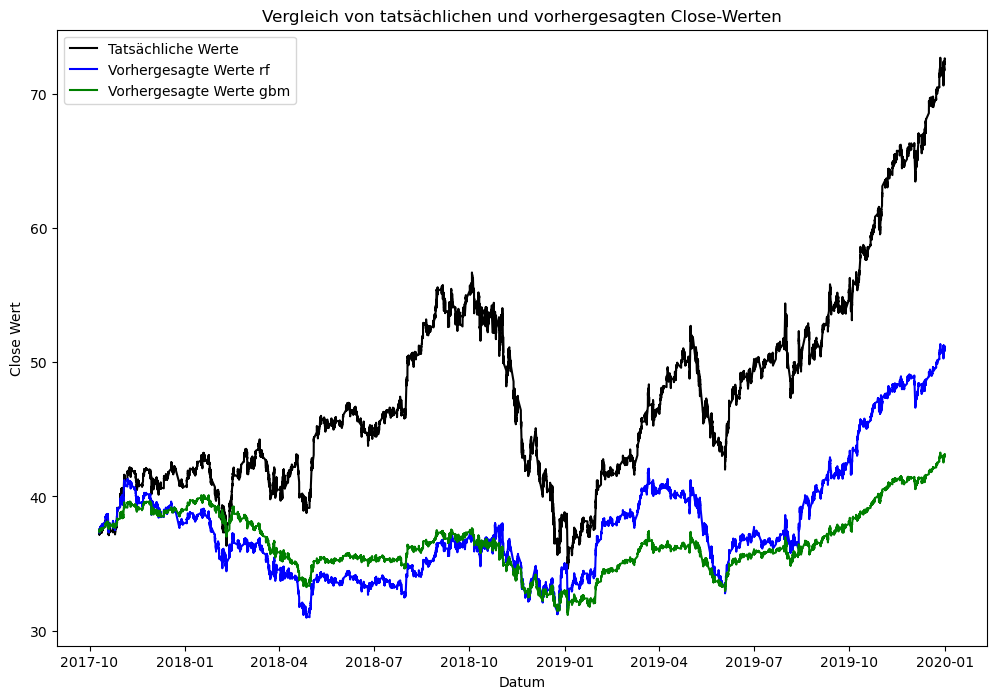

In [120]:
##plotten
lr_pred_column = reconstructed_df["lr_prediction"]  
rf_pred_column = reconstructed_df["rf_prediction"]
gbm_pred_column = reconstructed_df["gbm_prediction"]

# Liniendiagramm erstellen
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, actual_close_values, label='Tatsächliche Werte', color='black')
#plt.plot(y_test.index, lr_pred_column, label='Vorhergesagte Werte lr', color='red')
plt.plot(y_test.index, rf_pred_column, label='Vorhergesagte Werte rf', color='blue')
plt.plot(y_test.index, gbm_pred_column, label='Vorhergesagte Werte gbm', color='green')
plt.title('Vergleich von tatsächlichen und vorhergesagten Close-Werten')
plt.xlabel('Datum')
plt.ylabel('Close Wert')
plt.legend()
plt.show()
